# <font color="#fad961">━</font><font color="#f9c051">━━</font><font color="#f8a23f">━━━</font><font color="#f78d31">━━━━━</font><font color="#f77d27">━━━━━━</font><font color="#f76b1c">━━━━━━━━</font>    
# 1. 概要
# <font color="#fad961">━</font><font color="#f9c051">━━</font><font color="#f8a23f">━━━</font><font color="#f78d31">━━━━━</font><font color="#f77d27">━━━━━━</font><font color="#f76b1c">━━━━━━━━</font>  






○このプロジェクトは何か？  
1. Pythonを用いた感情分析プログラム
1. 使用データ：Kaggleより40,000行のテキストデータをダウンロード
1. 説明変数：英文のツイート / 目的変数：13種類の感情（正解としてラベリング済）
1. ランダムフォレストによる感情認識モデル構築  
1. 余力があれば他の予測モデル構築やデータハンドリングにより精度向上を図る





# <font color="#fdeb71">━</font><font color="#fce862">━━</font><font color="#fbe44a">━━━</font><font color="#fae136">━━━━━</font><font color="#f9dd1d">━━━━━━</font><font color="#f8d800">━━━━━━━━</font> 
# 2. データの準備  
# <font color="#fdeb71">━</font><font color="#fce862">━━</font><font color="#fbe44a">━━━</font><font color="#fae136">━━━━━</font><font color="#f9dd1d">━━━━━━</font><font color="#f8d800">━━━━━━━━</font> 



In [ ]:
#@title 2.1.1 Google ColaboratoryからGoogleドライブへマウント（アクセス可能にする）
from google.colab import drive
drive.mount('/content/drive')
# Google ColaboratoryはGoogleドライブへのアクセスが
# Googleドライブへのマウントのコードを毎回、Google Colaboratoryを開くたびに実行する必要がある
# 自分のドライブに関しては、毎回パスが通るようになる


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 最初に一回実行して、必要なデータをダウンロード
! wget "https://drive.google.com/uc?export=download&id=1-1JfQnvwyuO-UjiZQ78r6W15ZhK7gWBd"  -O tweet_emotions-UTF-8withBOM.csv

--2023-06-11 04:58:32--  https://drive.google.com/uc?export=download&id=1-1JfQnvwyuO-UjiZQ78r6W15ZhK7gWBd
Resolving drive.google.com (drive.google.com)... 142.251.31.138, 142.251.31.100, 142.251.31.102, ...
Connecting to drive.google.com (drive.google.com)|142.251.31.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-40-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qfidc3e5fqsjj063i7ab9av1vjtg36lc/1686459450000/10961314361702132281/*/1-1JfQnvwyuO-UjiZQ78r6W15ZhK7gWBd?e=download&uuid=0333d821-cff1-49f6-b720-70f056f8483a [following]
--2023-06-11 04:58:33--  https://doc-04-40-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qfidc3e5fqsjj063i7ab9av1vjtg36lc/1686459450000/10961314361702132281/*/1-1JfQnvwyuO-UjiZQ78r6W15ZhK7gWBd?e=download&uuid=0333d821-cff1-49f6-b720-70f056f8483a
Resolving doc-04-40-docs.googleusercontent.com (doc-04-40-docs.googleusercontent.com)... 108.177.126.132, 2a00

In [ ]:
# このプロジェクトの実行時間計測用
import time
start_time = time.time()

In [ ]:
#@title 2.1.2 データを保存して確認
import pandas as pd

# 文字化けで"quot"という字が多発したため、精度向上用に削除
delete_quot = True
if delete_quot:
  # Tweet = pd.read_csv('/content/drive/MyDrive/Data for Colab Notebooks/tweet_emotions-UTF-8withBOM.csv')
  Tweet = pd.read_csv('/content/tweet_emotions-UTF-8withBOM.csv')
else:
  Tweet = pd.read_csv('/content/drive/MyDrive/Data for Colab Notebooks/tweet_emotions_tweets_and_sentiments.csv', encoding='cp932')
Tweet

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1753745160,neutral,"@jishanvn yï¿½n tï¿½m, sang n?m s? th?y ti?t m..."
3,1956967696,sadness,Funeral ceremony...gloomy friday...
4,1956967789,enthusiasm,wants to hang out with friends SOON!
...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [ ]:
#@title 2.1.3 使わない列`tweet_id`を削除し、1.`content`（ツイート）2.`sentiment`（感情）の順に並べ替える
if delete_quot:
  Tweet.drop('tweet_id', axis=1, inplace=True)
  # content列 を先に表示させる
  Tweet = Tweet[['content', 'sentiment']]
  Tweet.head(3)

In [ ]:
#@title 2.1.4.1 目的変数修正
# 精度向上のため、目的変数の数を13個から6個に統合
# 削除したいクラス（目的変数）を書いて~を書くか、あるいは残したいクラスを書く
drop_class = ["neutral","worry", 'empty', 'boredom', 'enthusiasm']
# 削除項目を~で指定して、削除項目以外をすべて取り出す
# sentiment列にdrop_classが含まれていないレコードのみを取り出す
drop_Tweet = Tweet[~Tweet["sentiment"].isin(drop_class)]
print(f"行数: {len(drop_Tweet)} になったものの、あいまいな意味の感情クラスを削減して精度向上が可能")
drop_Tweet

行数: 21138 になったものの、あいまいな意味の感情クラスを削減して精度向上が可能


,content,sentiment
1,Layin n bed with a headache ughhhh...waitin o...,sadness
3,Funeral ceremony...gloomy friday...,sadness
7,"I should be sleep, but im not! thinking about ...",sadness
9,@charviray Charlene my love. I miss you,sadness
10,@kelcouch I'm sorry at least it's Friday?,sadness
...,...,...
39994,Succesfully following Tayla!!,happiness
39996,Happy Mothers Day All my love,love
39997,Happy Mother's Day to all the mommies out ther...,love
39998,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,happiness


In [ ]:
#@title 目的変数の削除をdfに適用
Tweet = drop_Tweet

In [ ]:
#@title 参考
# neutralの場所がTrueになる ~を付けると反対にfalseになる
~Tweet["sentiment"].isin(drop_class)

1        True
3        True
7        True
9        True
10       True
         ... 
39994    True
39996    True
39997    True
39998    True
39999    True
Name: sentiment, Length: 21138, dtype: bool

In [ ]:
#@title 次で使うwordsを調整するテスト
words = Tweet['sentiment'].unique()
words

array(['sadness', 'surprise', 'love', 'fun', 'hate', 'happiness',
       'relief', 'anger'], dtype=object)

<ipython-input-27-071b458ecee3>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(word_counts.index, rotation=45, ha='right', fontsize=16)


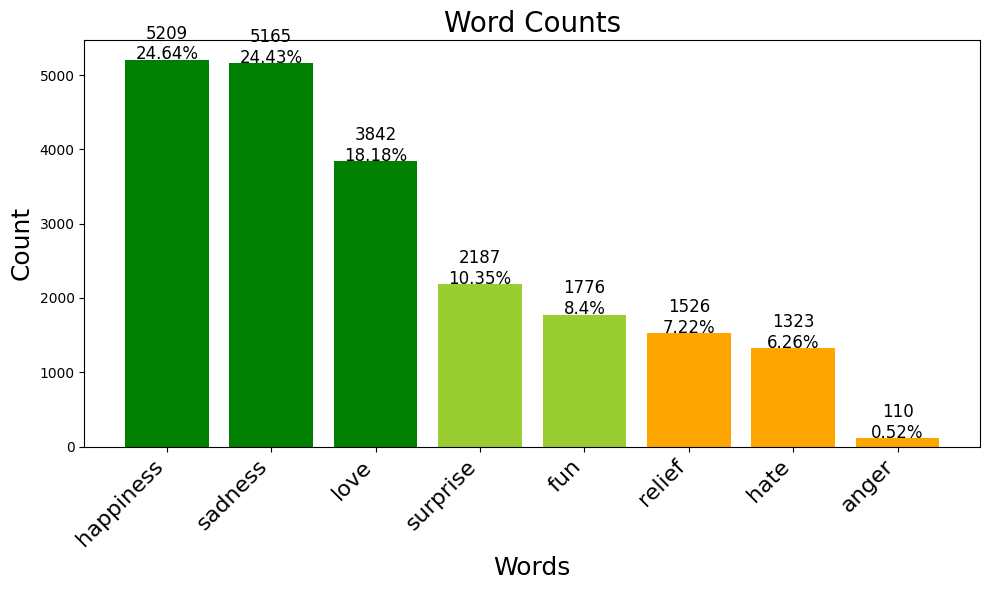

In [ ]:
#@title 2.1.4.3 目的変数である`sentiment`（感情）の割合を確認
import matplotlib.pyplot as plt

# 単語の出現回数をカウント
words = Tweet['sentiment'].unique()
# words = ['worry', 'surprise', 'sadness', 'empty', 'neutral', 'happiness',
#          'fun', 'love', 'relief', 'hate', 'boredom', 'enthusiasm', 'anger']
word_counts = pd.DataFrame(index=words, columns=['count'])
for word in words:
    word_counts.loc[word, 'count'] = Tweet.iloc[:, 1].str.count(word).sum()

# カウント数の降順にソート
word_counts = word_counts.sort_values('count', ascending=False)

# グラフの図と軸を作成し、サイズを設定
fig, ax = plt.subplots(figsize=(10, 6))

# 上位ほど寒色、下位が暖色になるように棒グラフ化
colors = ['green', 'green', 'green', 'yellowgreen', 'yellowgreen', 'orange', 'orange', 'orange', 'deepskyblue', 'red', 'aqua', 'yellow', 'blue']
ax.bar(word_counts.index, word_counts['count'], color=colors)

# x,y軸のラベルやグラフタイトルを設定
ax.set_xticklabels(word_counts.index, rotation=45, ha='right', fontsize=16)
ax.set_title('Word Counts', fontsize=20)
ax.set_xlabel('Words', fontsize=18)
ax.set_ylabel('Count', fontsize=18)

# 各棒の上にテキストを表示。テキストには出現回数と割合を表示する
for i, v in enumerate(word_counts['count']):
    ax.text(i, v+5, str(v) + '\n' + str(round(v / word_counts['count'].sum() * 100, 2)) + '%', ha='center', fontsize=12)

# グラフがはみ出さないようにレイアウトを調整して表示
plt.tight_layout()
plt.show()

In [ ]:
# データフレーム型でも確認
word_counts

,count
happiness,5209
sadness,5165
love,3842
surprise,2187
fun,1776
relief,1526
hate,1323
anger,110


In [ ]:
index_list = list(word_counts.index)
index_list

['happiness', 'sadness', 'love', 'surprise', 'fun', 'relief', 'hate', 'anger']

# <font color="#b1ea4d">━</font><font color="#d0e347">━━</font><font color="#bfd83b">━━━</font><font color="#a3c72a">━━━━━</font><font color="#8dba1b">━━━━━━</font><font color="#73AA0A">━━━━━━━━</font> 
# 2. データの整形  
# <font color="#b1ea4d">━</font><font color="#d0e347">━━</font><font color="#bfd83b">━━━</font><font color="#a3c72a">━━━━━</font><font color="#8dba1b">━━━━━━</font><font color="#73AA0A">━━━━━━━━</font> 

In [ ]:
#@title 2.2.1 頻出単語の削除
import nltk
import numpy as np
import pandas as pd
import re
import csv
from nltk.corpus import stopwords

# ストップワードリストを取得
# ツイートに最適化されたものではないため注意
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


もしエラーが出たら下記のようにコメントアウトする  
'''  
nltk.download('stopwords')  
stop_words = stopwords.words('english')  
'''  

### 2.2.1.1 疑似ストップワードリストを作成   
[方法はこちらを参照](https://qiita.com/takahiroaoi/items/fccfa0ba8726adcc2035#72-%E8%87%AA%E5%8A%9B%E3%81%A7ng%E3%83%AF%E3%83%BC%E3%83%89%E3%83%AA%E3%82%B9%E3%83%88%E3%82%92%E4%BD%9C%E6%88%90)

In [ ]:
#@title 2.2.1.1 自作の疑似ストップワードリストを取得
path = '/content/drive/MyDrive/Data for Colab Notebooks/20230303200335_頻出ワード100.xlsx'
df = pd.read_excel(path)
print("下記単語リストを \"delete_list\" として取得")
delete_list = df['word'].tolist()
delete_list

下記単語リストを "delete_list" として取得


['one',
 'the',
 'a',
 'that',
 'this',
 'an',
 'in',
 'for',
 'of',
 'on',
 'with',
 'at',
 'from',
 'about',
 'as',
 'm',
 'quot',
 'u',
 'i',
 's',
 't',
 'http',
 'im',
 'll',
 'you',
 'it',
 'me',
 'we',
 'they',
 'he',
 'my',
 'your',
 'its',
 'be',
 'was',
 'are',
 'am',
 'is']

In [ ]:
#@title 2.2.1.2 ツイートデータのクリーニングを定義
def tweet_to_words(raw_tweet,delete_list):

    # a~zまで始まる単語を空白ごとに区切ったリストを作成
    letters_only = re.sub("[^a-zA-Z@]", " ",raw_tweet) 
    words = letters_only.lower().split()

    # '@'が含まれる文字とストップワード (delete_list) を削除
    stops = set(delete_list)  
    meaningful_words = [w for w in words if not w in stops and not re.match("^[@]", w)]# and not re.match("",w)] 
    return( " ".join(meaningful_words)) 

In [ ]:
#@title 2.2.1.2 ツイートデータのクリーニング機能を作成（比較用に既存のストップワードリスト版を記載中）
# def tweet_to_words(raw_tweet):

#     # a~zまで始まる単語を空白ごとに区切ったリストを作成
#     letters_only = re.sub("[^a-zA-Z@]", " ",raw_tweet) 
#     words = letters_only.lower().split()

#     # '@'が含まれる文字とストップワードを削除
#     # stops = set(stopwords.words("english"))  
#     # meaningful_words = [w for w in words if not w in stops and not re.match("^[@]", w)]# and not re.match("",w)] 
#     meaningful_words = [w for w in words if not re.match("^[@]", w)]# and not re.match("",w)] 
#     return( " ".join(meaningful_words)) 
#     # return( " ".join(words)) 

In [ ]:
#@title 2.2.1.3 ツイートデータのクリーニングを実行
cleanTweet = Tweet['content'].apply(lambda x: tweet_to_words(x,delete_list))
clean_tweet_df = pd.DataFrame({'content': cleanTweet, 'sentiment': Tweet['sentiment']})

In [ ]:
#@title 2.2.1.3 ツイートデータのクリーニングを実行（比較用に既存のストップワードリスト版を記載中）
# cleanTweet = Tweet['content'].apply(lambda x: tweet_to_words(x))
# clean_tweet_df = pd.DataFrame({'content': cleanTweet, 'sentiment': Tweet['sentiment']})

In [ ]:
print(type(cleanTweet))
cleanTweet

<class 'pandas.core.series.Series'>


1                  layin n bed headache ughhhh waitin call
3                           funeral ceremony gloomy friday
7        should sleep but not thinking old friend who w...
9                                       charlene love miss
10                                      sorry least friday
                               ...                        
39994                          succesfully following tayla
39996                           happy mothers day all love
39997    happy mother day to all mommies out there woma...
39998    wassup beautiful follow peep out new hit singl...
39999    bullet train tokyo gf and have been visiting j...
Name: content, Length: 21138, dtype: object

In [ ]:
#@title 2.2.1.4 ツイートデータのクリーニング状況を確認
print("detele_liset の単語が除去されている")
clean_tweet_df

detele_liset の単語が除去されている


,content,sentiment
1,layin n bed headache ughhhh waitin call,sadness
3,funeral ceremony gloomy friday,sadness
7,should sleep but not thinking old friend who w...,sadness
9,charlene love miss,sadness
10,sorry least friday,sadness
...,...,...
39994,succesfully following tayla,happiness
39996,happy mothers day all love,love
39997,happy mother day to all mommies out there woma...,love
39998,wassup beautiful follow peep out new hit singl...,happiness


In [ ]:
# 以下のnltk実行時間を計測。処理効率や最適化の必要性があるどうかを n_end 取得時に判断
n_start = time.time()

In [ ]:
#@title 2.2.1.5 nltk を使った形態素解析、各単語のBaseForm化
 # 必要なライブラリのインストール
!pip install -U nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('wordnet')
# 単語の正規化
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_word(word, tag):
    if tag.startswith('NN'):
        return lemmatizer.lemmatize(word, pos='n')
    elif tag.startswith('VB'):
        return lemmatizer.lemmatize(word, pos='v')
    elif tag.startswith('JJ'):
        return lemmatizer.lemmatize(word, pos='a')
    elif tag.startswith('R'):
        return lemmatizer.lemmatize(word, pos='r')
    else:
        return word

# 形態素解析
from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords

# stop_words = set(stopwords.words('english'))

def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    tagged_tokens = nltk.pos_tag(tokens)
    lemmatized_tokens = [lemmatize_word(token, tag) for token, tag in tagged_tokens]
    return [token.lower() for token in lemmatized_tokens if token.isalpha()]

clean_tweet_df['tokens'] = clean_tweet_df['content'].apply(tokenize_text)

# 変換履歴の表示
import itertools

def print_transformation_history(original_token, final_token):
    if original_token != final_token:
        print(f"{original_token} → {final_token}")

def print_top_transformation_history(df, n=10):
    all_tokens = list(itertools.chain.from_iterable(df['tokens']))
    transformed_tokens = list(itertools.chain.from_iterable(df['tokens_transformed']))
    transformed_count = len([t for t in transformed_tokens if t != ''])
    print(f"Total number of transformations: {transformed_count}")
    print("\nTop transformation history:")
    for original_token, final_token in itertools.zip_longest(all_tokens, transformed_tokens):
        if original_token is None or final_token is None:
            break
        print_transformation_history(original_token, final_token)
        n -= 1
        if n == 0:
            break

# 語幹の変換
import inflect
p = inflect.engine()

def stem_transform(token):
    return p.singular_noun(token) or token

clean_tweet_df['tokens_transformed'] = clean_tweet_df['tokens'].apply(lambda x: [stem_transform(token) for token in x])

# 過去形、進行形の変換
from textblob import TextBlob

def verb_transform(token):
    blob = TextBlob(token)
    if blob.tags[0][1] == 'VBD' or blob.tags[0][1] == 'VBN':
        return blob.words[0].lemmatize('v')
    elif blob.tags[0][1] == 'VBG':
        return blob.words[0].lemmatize('v')[:-1]
    else:
        return token

# clean_tweet_df['tokens_transformed'] = clean_tweet_df['tokens_transformed'].apply(lambda x: [verb_transform(token) for token in x])
clean_tweet_df['tokens_transformed'] = clean_tweet_df['tokens_transformed'].apply(lambda x: ' '.join([verb_transform(token) for token in x]))

# 変換履歴の表示
print_top_transformation_history(clean_tweet_df)
clean_tweet_df

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


Total number of transformations: 1079654

Top transformation history:
layin → l
n → a
bed → y
headache → i
ughhhh → n
waitin →  
call → n
funeral →  
ceremony → b
gloomy → e


,content,sentiment,tokens,tokens_transformed
1,layin n bed headache ughhhh waitin call,sadness,"[layin, n, bed, headache, ughhhh, waitin, call]",layin n bed headache ughhhh waitin call
3,funeral ceremony gloomy friday,sadness,"[funeral, ceremony, gloomy, friday]",funeral ceremony gloomy friday
7,should sleep but not thinking old friend who w...,sadness,"[should, sleep, but, not, think, old, friend, ...",should sleep but not think old friend who want...
9,charlene love miss,sadness,"[charlene, love, miss]",charlene love mis
10,sorry least friday,sadness,"[sorry, least, friday]",sorry least friday
...,...,...,...,...
39994,succesfully following tayla,happiness,"[succesfully, follow, tayla]",succesfully follow tayla
39996,happy mothers day all love,love,"[happy, mother, day, all, love]",happy mother day all love
39997,happy mother day to all mommies out there woma...,love,"[happy, mother, day, to, all, mommy, out, ther...",happy mother day to all mommy out there woman ...
39998,wassup beautiful follow peep out new hit singl...,happiness,"[wassup, beautiful, follow, peep, out, new, hi...",wassup beautiful follow peep out new hit singl...


In [ ]:
# 上記時間測定結果
n_end = time.time()
n_time = n_end - n_start
if n_time < 180:
    print("Elapsed time nltk時間: {:.2f} sec".format(n_time))
else:
    print("Elapsed time nltk時間: {:.2f} sec".format(n_time))
    print("処理短縮を検討（パラレル処理、バッチ処理、辞書やキャッシュの活用）")

Elapsed time nltk時間: 7.34 sec


In [ ]:
type(clean_tweet_df['tokens_transformed'][1])

str

In [ ]:
#@title 不要？
# # tokens_transformed列の整形
# # clean_tweet_df['content'] = clean_tweet_df['tokens_transformed'].str.replace('[\[\]]', '').str.replace(',', ' ')
# clean_tweet_df['content'] = clean_tweet_df['tokens_transformed'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
# clean_tweet_df.drop(columns=['tokens_transformed'], inplace=True)

# # 3列目以降の削除
# clean_tweet_df = clean_tweet_df.iloc[:, :2]

# # 結果の表示
# print(clean_tweet_df)

In [ ]:
cleanTweet_2 = cleanTweet
# print(type(cleanTweet_2),type(cleanTweet_2[0]))
cleanTweet_2

1                  layin n bed headache ughhhh waitin call
3                           funeral ceremony gloomy friday
7        should sleep but not thinking old friend who w...
9                                       charlene love miss
10                                      sorry least friday
                               ...                        
39994                          succesfully following tayla
39996                           happy mothers day all love
39997    happy mother day to all mommies out there woma...
39998    wassup beautiful follow peep out new hit singl...
39999    bullet train tokyo gf and have been visiting j...
Name: content, Length: 21138, dtype: object

In [ ]:
cleanTweet_2.values.tolist()

['layin n bed headache ughhhh waitin call',
 'funeral ceremony gloomy friday',
 'should sleep but not thinking old friend who want but married now damn amp wants scandalous',
 'charlene love miss',
 'sorry least friday',
 'ugh have to beat stupid song to get to next rude',
 'if watch hills london will realise what tourture because were weeks and weeks late just watch itonlinelol',
 'got news',
 'storm here and electricity gone',
 'agreed',
 'so sleepy again and not even late fail once again',
 'how convinced have always wanted what signals did give off damn think just lost another friend',
 'wondering why awake writing new song plotting evil secret plots muahahaha oh damn not secret anymore',
 'so tired and think definitely going to get ear infection going to bed early once',
 'sorry people so rude to isaac should get some manners and know better than to so lewd',
 'fudge just bs d whole paper so tired ugh hate school time to sleep',
 'so annoying when she starts typing her computer mi

In [ ]:
#@title 2.2.2 単語のデータベースを作成
# データセット内のツイートをすべて半角スペースで連結して、1つの文字列にする
all_text = ' '.join(clean_tweet_df['tokens_transformed'].values.tolist())
# 上記の1つの文字列を半角スペースごとに分割して、たくさんの単語リストにする
many_words = all_text.split()
# 同じ単語も出現タイミングによって別々にカウントする
print("単語のデータベース作成完了 / 単語の総個数：" + str(len(many_words)))

単語のデータベース作成完了 / 単語の総個数：207180


In [ ]:
#@title 2.2.2.2 単語ごとの出現回数をカウント
from collections import Counter
counts = Counter(many_words)
print("登場単語の種類："+ str(len(counts))+"語")

# 単語ごとの出現回数を見たいので、データフレームに変換
counts_df = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])
counts_df_sorted = counts_df.sort_values('count', ascending=False)

transposed_df = counts_df_sorted.transpose()
print(transposed_df.columns[0] + str(" や ") + transposed_df.columns[1] + str("が多いことが分かる"))  
transposed_df.head(20)

登場単語の種類：17908語
to や andが多いことが分かる


,to,and,have,day,get,so,go,just,but,good,...,rught,shippuuden,meaner,polka,glam,wxa,obnoxiou,bananabrain,oepn,godzilla
count,7553,4211,3366,2534,2418,2219,2047,1783,1762,1630,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
#@title 2.2.3 単語の数値化
# Counterオブジェクトの単語データベースを、降順のリスト型に変換
vocab = sorted(counts, key=counts.get, reverse=True)

# 単語ごとにIDを割当てた辞書を作成
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

# リスト内包表記を使って各単語をIDに変換したリスト tweet_ints を作成
tweet_ints = []
for each in clean_tweet_df['tokens_transformed']:
    tweet_ints.append([vocab_to_int[word] for word in each.split()])

# print(cleanTweet[0])
print(clean_tweet_df['tokens_transformed'].iloc[4])  
print("↓単語ごと数値化")  
# print(tweet_ints)
print(tweet_ints[4])

sorry least friday
↓単語ごと数値化
[113, 316, 205]


In [ ]:
cleanTweet.iloc[0]

'layin n bed headache ughhhh waitin call'

In [ ]:
#@title 2.2.4 列の長さを確認
# 各ツイートが持っている不揃いな状態の単語数を調査
tweet_len = Counter([len(x) for x in tweet_ints])
seq_len = max(tweet_len)
print("Zero-length reviews（単語数が0個のツイート数）: {}".format(tweet_len[0]))
print("Maximum review length（単語数の最大値）: {}".format(seq_len))

Zero-length reviews（単語数が0個のツイート数）: 6
Maximum review length（単語数の最大値）: 28


In [ ]:
#@title 2.2.4.1 欠損値の削除
# テキストクリーニングで単語数が0になっている行を飛ばした「index番号リスト」を作成
no_missing_idx  = [idx for idx,tweet in enumerate(tweet_ints) if len(tweet) > 0]
clean_tweet_df = clean_tweet_df.iloc[no_missing_idx]
tweet_ints = [tweet for tweet in tweet_ints if len(tweet) > 0]

print("clean_tweet_df（欠損値削除後のデータフレーム）：" + str(clean_tweet_df.shape))

clean_tweet_df（欠損値削除後のデータフレーム）：(21132, 4)


In [ ]:
#@title 2.2.5.4 列数を揃えるためにi行ごとの数値化した単語を右から書いた形式に変更
# 右詰めの理由：どちらでも良いが、今回は右詰め
# Point: 長さがそろっていることが重要
# tweet_ints = [tweet for tweet in tweet_ints if len(tweet) > 0]
# np.zeros：準備として39920*39の0だけが入った、np配列を作成
features = np.zeros((len(tweet_ints), seq_len), dtype=int)
# iには0から順番に入っていく。rowにはtweet_ints（単語を数値に置き換えたもの）が入っていく
for i, row in enumerate(tweet_ints):
    # iは行の指定に使われる。i番目のデータを操作する。
    # -len(row):には単語数が入る。-で右から単語数個以降の要素に、右辺の要素を入れる
    features[i, -len(row):] = np.array(row)[:seq_len]
print("numpy配列の形："+ str(features.shape))

numpy配列の形：(21132, 28)


In [ ]:
np.set_printoptions(threshold=np.inf, linewidth=240)  # numpyの出力オプションを横長に変更
print(features[0:4])
print("中略")
print(features[len(tweet_ints)-5:len(tweet_ints)])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 7404  193  114  437 2560 1830  162]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 1831 3344 1488  205]
 [   0    0    0    0    0    0    0    0    0    0    0    0  129  110    9   14   38  195   80  151   40    9  911   16  196   41   40 7405]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 7406   11   31]]
中略
[[    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0 17904   142  5552]
 [    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0    15    23     4    13    11]
 [    0     0     0     0     0     0     0     0     0     0     0    15    23   

In [ ]:
#@title 2.4 感情13種類の数値化
# unique()：データフレームの指定列の重複を削除
# labels = clean_tweet_df["sentiment"].unique()
labels = index_list
# 正解ラベルの数（13）をrange(0～12)で作成。"13"ではなく"13個の数値"なのがポイント
num = list(range(len(labels)))

print(type(labels),type(num))
print("\nまずは以下の2つの配列を作成")
print(labels)
print(num)

<class 'list'> <class 'list'>

まずは以下の2つの配列を作成
['happiness', 'sadness', 'love', 'surprise', 'fun', 'relief', 'hate', 'anger']
[0, 1, 2, 3, 4, 5, 6, 7]


In [ ]:
#@title 2.4.2 次にmap()を行うために辞書化
# worryと0を取り出して...という処理を12回繰り返す。少ない方のリストに合わされる
label_dic = dict(zip(labels,num))
print(label_dic)

{'happiness': 0, 'sadness': 1, 'love': 2, 'surprise': 3, 'fun': 4, 'relief': 5, 'hate': 6, 'anger': 7}


In [ ]:
#辞書を作る理由：新しい列名を作る。どんなデータを入れるか。既存の文字列のデータに対して、mapで対象する数値を指定していきたい
#map関数を使うためには、辞書型か関数じゃないと引数に指定できない
#このやり方がシンプルにできそうなので、今回はこのようにしている

In [ ]:
clean_tweet_df["sentiment_label"] = clean_tweet_df["sentiment"].map(label_dic)
clean_tweet_df

<ipython-input-38-1fb98e01d7f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_tweet_df["sentiment_label"] = clean_tweet_df["sentiment"].map(label_dic)


,content,sentiment,tokens,tokens_transformed,sentiment_label
1,layin n bed headache ughhhh waitin call,sadness,"[layin, n, bed, headache, ughhhh, waitin, call]",layin n bed headache ughhhh waitin call,1
3,funeral ceremony gloomy friday,sadness,"[funeral, ceremony, gloomy, friday]",funeral ceremony gloomy friday,1
7,should sleep but not thinking old friend who w...,sadness,"[should, sleep, but, not, think, old, friend, ...",should sleep but not think old friend who want...,1
9,charlene love miss,sadness,"[charlene, love, miss]",charlene love mis,1
10,sorry least friday,sadness,"[sorry, least, friday]",sorry least friday,1
...,...,...,...,...,...
39994,succesfully following tayla,happiness,"[succesfully, follow, tayla]",succesfully follow tayla,0
39996,happy mothers day all love,love,"[happy, mother, day, all, love]",happy mother day all love,2
39997,happy mother day to all mommies out there woma...,love,"[happy, mother, day, to, all, mommy, out, ther...",happy mother day to all mommy out there woman ...,2
39998,wassup beautiful follow peep out new hit singl...,happiness,"[wassup, beautiful, follow, peep, out, new, hi...",wassup beautiful follow peep out new hit singl...,0


# <font color="#00f198">━</font><font color="#00f1a4">━━</font><font color="#02f2b3">━━━</font><font color="#03f3ca">━━━━━</font><font color="#05f4db">━━━━━━</font><font color="#07f6f6">━━━━━━━━</font>    
# 3. 予測モデル構築
# <font color="#00f198">━</font><font color="#00f1a4">━━</font><font color="#02f2b3">━━━</font><font color="#03f3ca">━━━━━</font><font color="#05f4db">━━━━━━</font><font color="#07f6f6">━━━━━━━━</font>   

In [ ]:
#@title 3.1 学習データ（7割）とテストデータ（3割）の生成
from sklearn.model_selection import train_test_split
# 特徴量として、numpy配列化した単語群を説明変数 X とする
X = features
# 正解ラベルとして、dfの数値化した感情群を目的変数 y とする
y = clean_tweet_df.sentiment_label
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
#@title 3.2 モデル構築
from sklearn.ensemble import RandomForestClassifier
ne = 221
rs = 42
model1 = RandomForestClassifier(n_estimators=ne, random_state=rs)

In [ ]:
#@title 3.3 モデルの学習
# 学習時間測定
trian_start = time.time()

model1.fit(train_X, train_y)

trian_end = time.time()
train_time = trian_end - trian_start
print("Elapsed time 学習時間: {:.2f} sec".format(train_time))

Elapsed time 学習時間: 19.46 sec


In [ ]:
#@title 3.4 正解率を算出
print("ランダムフォレスト: {}".format(model1.score(test_X, test_y)))

ランダムフォレスト: 0.3359621451104101


In [ ]:
print(str(time.time())+"n estimator： "+str(n_estimator))

NameError: ignored

<font color="#b1ea4d">━</font><font color="#d0e347">━━</font><font color="#bfd83b">━━━</font><font color="#a3c72a">━━━━━</font><font color="#8dba1b">━━━━━━</font><font color="#73AA0A">━━━━━━━━</font>  
# 4. 可視化・考察
<font color="#b1ea4d">━</font><font color="#d0e347">━━</font><font color="#bfd83b">━━━</font><font color="#a3c72a">━━━━━</font><font color="#8dba1b">━━━━━━</font><font color="#73AA0A">━━━━━━━━</font>  

In [ ]:
#@title 4.1.1 ランダムフォレストの予測値（混同行列用）
y_pred = model1.predict(test_X)

In [ ]:
#@title 4.1.2 正解率を混同行列にて算出
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
y_true = test_y #正解のラベル
conf_matrix  = confusion_matrix(y_true,y_pred)

print("テストデータ総個数: {}".format(np.sum(conf_matrix))+"\n")
print(conf_matrix)

テストデータ総個数: 6340

[[ 772  576  187   31   27   12    4    0]
 [ 343 1063   96   24    4    5   12    0]
 [ 415  427  261   22   10    6    2    0]
 [ 223  363   41   16    5    1    3    0]
 [ 209  216   51    9    5    2    1    0]
 [ 148  231   56    7    1    2    1    0]
 [  96  277   19    6    2    1   11    0]
 [  12   24    2    0    0    0    0    0]]


In [ ]:
#@title 4.1.2 混同行列をヒートマップ風データフレームに
conf_matrix_df = pd.DataFrame(conf_matrix, columns = labels, index = labels)

print("混同が多くみられるほど濃い緑になる")
def highlight(value):
    if value < 0:
        return 'background-color: honeydew    '
    elif value == 0:
        return 'background-color: palegreen  '
    elif 1 <= value <= 20:
        return 'background-color: lightgreen  '
    elif 20 < value <= 50:
        return 'background-color: greenyellow  '
    elif 51 <= value <= 100:
        return 'background-color: limegreen  '
    elif 101 <= value <= 500:
        return 'background-color: forestgreen   '
    else:
        return 'background-color: darkgreen  '

# スタイルを適用して表示する
conf_matrix_df.style.applymap(highlight)

混同が多くみられるほど濃い緑になる


,happiness,sadness,love,surprise,fun,relief,hate,anger
happiness,772,576,187,31,27,12,4,0
sadness,343,1063,96,24,4,5,12,0
love,415,427,261,22,10,6,2,0
surprise,223,363,41,16,5,1,3,0
fun,209,216,51,9,5,2,1,0
relief,148,231,56,7,1,2,1,0
hate,96,277,19,6,2,1,11,0
anger,12,24,2,0,0,0,0,0


In [ ]:
# 各列の合計を計算して予測数合計という行を作成
conf_matrix_df.loc['予測数合計'] = conf_matrix_df.sum()

# 結果の表示
conf_matrix_df

,happiness,sadness,love,surprise,fun,relief,hate,anger
happiness,772,576,187,31,27,12,4,0
sadness,343,1063,96,24,4,5,12,0
love,415,427,261,22,10,6,2,0
surprise,223,363,41,16,5,1,3,0
fun,209,216,51,9,5,2,1,0
relief,148,231,56,7,1,2,1,0
hate,96,277,19,6,2,1,11,0
anger,12,24,2,0,0,0,0,0
予測数合計,2218,3177,713,115,54,29,34,0


In [ ]:
# 新しい列を作成して、各行の合計値を計算する
conf_matrix_df['正解数合計'] = conf_matrix_df.sum(axis=1)

# データフレームを表示する
conf_matrix_df


,happiness,sadness,love,surprise,fun,relief,hate,anger,正解数合計
happiness,772,576,187,31,27,12,4,0,1609
sadness,343,1063,96,24,4,5,12,0,1547
love,415,427,261,22,10,6,2,0,1143
surprise,223,363,41,16,5,1,3,0,652
fun,209,216,51,9,5,2,1,0,493
relief,148,231,56,7,1,2,1,0,446
hate,96,277,19,6,2,1,11,0,412
anger,12,24,2,0,0,0,0,0,38
予測数合計,2218,3177,713,115,54,29,34,0,6340


In [ ]:
# conf_matrix_df.loc['正解率'] = ['28%', '24%', '6%', '17%', '0%', '16%', '0%', '40%', '5%', '7%', '0%', '0%', '0%']
# conf_matrix_df

In [ ]:
# conf_matrix_df2 = conf_matrix_df
# conf_matrix_df2

In [ ]:
# conf_matrix_df2.insert(13, '合計', [2616, 2555, 633, 1578, 222, 1562, 511, 1142, 438, 407, 59, 217, 36, 11976, np.nan], True)
# conf_matrix_df2.insert(14, '割合', ['44%', '63%', '0%', '5%', '0%', '5%', '0%', '8%', '0%', '0%', '0%', '0%', '0%', '34%', np.nan], True)
# conf_matrix_df2

In [ ]:
#@title 4.2 後で比較するためのデータ保存
from datetime import datetime
import pytz
jst = pytz.timezone('Asia/Tokyo')
now = datetime.now(jst)
filename = "感情分析_精度"+ str(model1.score(test_X, test_y))[:6]+"_rs"+str(rs)+"ne"+str(ne)+ "_学習"+ str(train_time)[:5]+"秒"
pathname = "/content/drive/MyDrive/Data for Colab Notebooks/1st_sentiment analysis/"
conf_matrix_name = pathname + now.strftime('%Y%m%d-%H%M')+ "_" + filename + "_conf_matrix.csv"
print(conf_matrix_name)
conf_matrix_df.to_csv(conf_matrix_name, index=True)

/content/drive/MyDrive/Data for Colab Notebooks/1st_sentiment analysis/20230305-1800_感情分析_精度0.3359_rs42ne221_学習19.46秒_conf_matrix.csv


In [ ]:
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time 経過時間: {:.2f} sec".format(elapsed_time))
print("学習"+ str(train_time)[:5]+"秒")

Elapsed time 経過時間: 1768.45 sec
学習19.46秒


In [ ]:
#@title ブレイクポイント
# from IPython.core.debugger import Pdb; Pdb().set_trace()
# pdbの基本的なコマンドは以下のとおりです。

#     h [command]：ヘルプを出す
#     p [expression]：式を評価して出力する
#     n：次の行へ
#     c：次のブレークポイントへ
#     q：その場で終了する

In [ ]:
#@title 4.3.1-a もし決定木のモデル構築していれば正解率を混同行列にて算出
if 'model2' in globals():
  print("決定木：")
  # 決定木の予測値（混同行列用）
  y_pred2 = model2.predict(test_X)
  conf_matrix2  = confusion_matrix(y_true,y_pred2)
  print(conf_matrix2)
  conpare_filename = "感情分析_ver.1.0_精度15.8%_決定木"
  read_r_forest = False
else:
  read_r_forest = True

In [ ]:
#@title 4.3.1-b 比較対象の混同行列を呼び出す
read_r_forest = 1
if read_r_forest:
  import os
  csv_file = "/content/drive/MyDrive/Data for Colab Notebooks/1st_sentiment analysis/20230304-0327_感情分析_精度0.2549_rs42ne331_学習71.10秒_conf_matrix.csv"
  s =  os.path.basename(csv_file)
  conpare_filename = s[:s.index("_conf")] # ファイル名の長さ調整
  saved_df = pd.read_csv(csv_file, index_col=0)
  # deleted_index_df = saved_df.iloc[:, 1:]
  # comparable_np_array = deleted_index_df.values
  print("比較対象のbaseデータフレーム：\n")
saved_df

比較対象のbaseデータフレーム：



,neutral,worry,happiness,sadness,love,surprise,fun,relief,hate,empty,enthusiasm,boredom,anger,正解数合計
neutral,1171,1172,105,88,44,12,6,6,5,6,1,0,0,2616
worry,743,1619,57,103,13,8,2,5,1,2,2,0,0,2555
happiness,568,823,89,43,28,5,2,2,0,1,1,0,0,1562
sadness,445,998,37,79,7,5,2,1,3,0,0,1,0,1578
love,315,630,49,47,90,3,1,4,0,1,1,0,1,1142
surprise,237,341,19,22,9,2,1,0,0,1,1,0,0,633
fun,146,322,20,14,4,2,0,2,0,0,0,0,1,511
relief,133,255,19,21,8,0,1,1,0,0,0,0,0,438
hate,119,260,8,11,3,2,0,1,2,1,0,0,0,407
empty,105,95,8,10,2,0,1,0,0,0,1,0,0,222
